In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import time
from torch import nn
from sklearn.cluster import KMeans

In [2]:
# just an utils function
def classlookup(cls):
    c = list(cls.__bases__)
    for base in c:
        c.extend(classlookup(base))
    return c

In [3]:
from abc import ABC, abstractmethod

In [6]:
def kmeans_elbow(dataset):
    inertias = []
    d_inertias = []
    dd_inertias = []
    k = 1
    max_val = 0
    max_k = 0
    updating = True
    while updating:
        updating = False
        for i in range(5):
            kmeans_res = KMeans(n_clusters=k).fit(dataset)
            inertias.append(kmeans_res.inertia_)
            if k > 1:
                d_inertias.append(inertias[-1]-inertias[-2])
            if k > 2:
                val = d_inertias[-1]-d_inertias[-2]
                dd_inertias.append(val)
                if val > max_val:
                    max_k = k
                    max_val = val
                    updating = True
            k += 1

    return max_k - 1

In [7]:
def decimal_part(x):
    return x - int(x)

In [8]:
# DO I KEEP THIS THOUGH
# also torch.utils.data.Sampler exists -> put it in dataloader constructor

class Sampler(ABC):
    @abstractmethod
    def __init__(self, dataset, batch_size):
        pass

    @abstractmethod
    def __call__(self):
        pass
        
class RandomSampler(Sampler):
    def __init__(self, dataset, batch_size):
        self.n = len(dataset)
        self.batch_size = batch_size

    def __call__(self):
        return np.random.randint(0, self.n, (self.batch_size,))

class SuccessiveSampler(Sampler):
    def __init__(self, dataset, batch_size):
        self.i = 0
        self.n = len(dataset)
        self.indexes = np.arange(self.n)
        self.batch_size = batch_size

    def __call__(self):
        if self.i == 0:
            np.random.shuffle(self.indexes)
        inter = (self.i, min(self.i + self.batch_size, self.n))
        self.i += self.batch_size
        if self.i >= self.n:
            self.i = 0
        return self.indexes[inter[0]:inter[1]]

class ClusterSampler(Sampler):
    def __init__(self, dataset, batch_size):
        ideal_k = kmeans_elbow(dataset)
        kmeans_res = KMeans(n_clusters=ideal_k).fit(dataset)
        self.cluster_count = ideal_k
        self.clusters = [np.array([], dtype=np.uint32) for _ in range(self.cluster_count)]
        for i, l in enumerate(kmeans_res.labels_):
            self.clusters[l] = np.append(self.clusters[l], i)

        self.n = len(dataset)
        self.batch_size = batch_size
        
        # idea: we always sample the cluster_size*B//N
        self.sample_count = [len(self.clusters[i])*batch_size//self.n
                             for i in range(self.cluster_count)]

        self.added_count = self.batch_size - sum(self.sample_count)
        self.added_probs =  np.array([len(self.clusters[i])*batch_size%self.n
                             for i in range(self.cluster_count)], dtype=np.float64)
        self.added_probs /= np.sum(self.added_probs)
        # print(*(len(c) for c in self.clusters))
        # print(self.sample_count)
        # print(self.added_probs)

    def __call__(self):
        added = np.random.choice(self.cluster_count, self.added_count, p=self.added_probs)
        sample_count = self.sample_count[:]
        for i_added in added:
            sample_count[i_added] += 1
        
        # print(sample_count)

        batch = np.array([], dtype=np.uint32)
        for i_cluster in range(self.cluster_count):
            selected = np.random.choice(self.clusters[i_cluster], sample_count[i_cluster])
            batch = np.append(batch, selected)

        return batch


In [9]:
from torch import nn
import copy

class LogisticModel(nn.Module):
    def __init__(self, dataset):
        super().__init__()
        assert len(dataset.shape) == 2, "Do not use with images"
        dim = dataset.shape[1]
        self.layer = nn.Linear(dim, 1)
    
    def forward(self, ai):
        x = self.layer(ai)
        res = torch.log(1 + torch.exp(x))
        return res.flatten()
    
def logit_criterion(output, batch):
    return output.mean()

In [10]:
torch.manual_seed(42)
np.random.seed(42)

DATASET_SIZE = 1000
DATASET_DIM = 2
DATASET_CLUSTER_COUNT = 4
DATASET_R = 5

cluster_lims = np.sort(
    np.append(np.random.choice(np.arange(1,DATASET_SIZE), 
                               size=DATASET_CLUSTER_COUNT-1, 
                               replace=False),[0,DATASET_SIZE]))

cluster_lims
# cluster_lims = [i*DATASET_SIZE//DATASET_CLUSTER_COUNT for i in range(DATASET_CLUSTER_COUNT+1)]

array([   0,  210,  454,  794, 1000])

In [11]:
clustered_data = torch.randn(DATASET_SIZE, DATASET_DIM).float()
for i in range(DATASET_CLUSTER_COUNT):
    vec = np.random.randn(DATASET_DIM)
    vec = vec / np.linalg.norm(vec)
    clustered_data[cluster_lims[i]:cluster_lims[i+1], :] += DATASET_R * vec

C:\Users\yyeah\AppData\Local\Temp\ipykernel_12040\3951682972.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  clustered_data[cluster_lims[i]:cluster_lims[i+1], :] += DATASET_R * vec


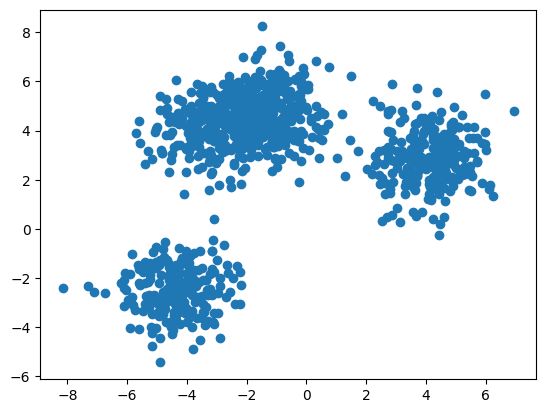

In [12]:
plt.scatter(clustered_data[:,0], clustered_data[:,1])

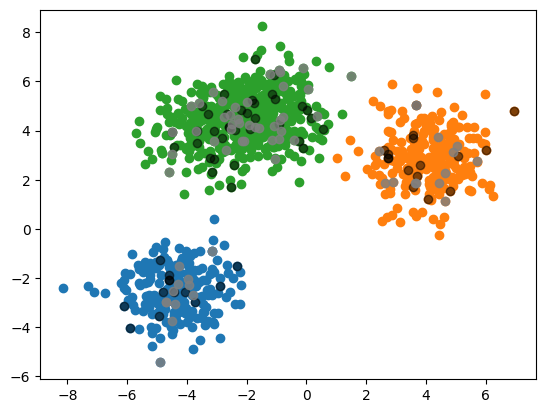

In [13]:
sampler = ClusterSampler(clustered_data, 64)
for i in range(sampler.cluster_count):
    selected = clustered_data[sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
batch = sampler()
sampled = clustered_data[batch]
plt.scatter(sampled[:,0], sampled[:,1], color="black", alpha=0.5)
random_sample = clustered_data[np.random.choice(DATASET_SIZE, 64)]
plt.scatter(random_sample[:,0], random_sample[:,1], color="gray", alpha=0.8)
plt.show()

In [14]:
from torch.optim.optimizer import Optimizer, required

class SVRG(Optimizer):
    r""" implement SVRG """ 

    def __init__(self, params, lr=required, freq=10):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr, freq=freq)
        self.counter = 0 # counts inner / outer iterations
        self.flag = False
        super(SVRG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SVRG, self).__setstate__(state)
        # for group in self.param_groups:
        #     group.setdefault('m', )

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            freq = group['freq']
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                param_state = self.state[p]
                
                if 'large_batch' not in param_state:
                    buf = param_state['large_batch'] = torch.zeros_like(p.data)
                    buf.add_(d_p) #add first large, low variance batch
                    #need to add the second term in the step equation; the gradient for the original step!
                    buf2 = param_state['small_batch'] = torch.zeros_like(p.data)

                buf = param_state['large_batch']
                buf2 = param_state['small_batch']

                if self.counter == freq:
                    buf.data = d_p.clone() #copy new large batch. Begining of new inner loop
                    temp = torch.zeros_like(p.data)
                    buf2.data = temp.clone()
                    
                if self.counter == 1:
                    buf2.data.add_(d_p) #first small batch gradient for inner loop!

                #dont update parameters when computing large batch (low variance gradients)
                if self.counter != freq and self.flag != False:
                    p.data.add_(-group['lr'], (d_p - buf2 + buf) )

        self.flag = True #rough way of not updating the weights the FIRST time we calculate the large batch gradient
        
        if self.counter == freq:
            self.counter = 0

        self.counter += 1    

        return loss

In [16]:
model = LogisticModel(clustered_data)
optimizer = SVRG(model.parameters(), lr=0.01)

In [23]:
print(*model.parameters())

Parameter containing:
tensor([[-0.2945, -0.0366]], requires_grad=True) Parameter containing:
tensor([-0.4972], requires_grad=True)


In [31]:
print(optimizer.state)

defaultdict(<class 'dict'>, {Parameter containing:
tensor([[-0.2945, -0.0366]], requires_grad=True): {}, Parameter containing:
tensor([-0.4972], requires_grad=True): {}})


In [33]:
for group in optimizer.param_groups:
    # print(group)
    freq = group['freq']
    # print(freq)
    for p in group['params']:
        d_p = p.grad.data
        print(p, d_p)
        param_state = optimizer.state[p]
        print(optimizer.state[p])
        buf = param_state['large_batch'] = torch.zeros_like(p.data)
        buf.add_(d_p)

Parameter containing:
tensor([[-0.2945, -0.0366]], requires_grad=True) tensor([[-1.1255,  0.9227]])
{}
Parameter containing:
tensor([-0.4972], requires_grad=True) tensor([0.4481])
{}


In [34]:
for group in optimizer.param_groups:
    for p in group['params']:
        print(optimizer.state[p]["large_batch"])

tensor([[-1.1255,  0.9227]])
tensor([0.4481])


In [29]:
res = model(clustered_data)
loss = logit_criterion(res, 64)
optimizer.zero_grad()
loss.backward()

In [ ]:
# from GPT
# class SVRG(torch.optim.Optimizer):
#     def __init__(self, params, lr=0.01, n_inner=10):
#         defaults = dict(lr=lr, n_inner=n_inner)
#         super(SVRG, self).__init__(params, defaults)

#     def step(self, closure):
#         """
#         closure: A function that re-evaluates the model and returns the loss.
#         """
#         # Extract hyperparameters
#         lr = self.param_groups[0]['lr']
#         n_inner = self.param_groups[0]['n_inner']
#         params = self.param_groups[0]['params']

#         # Take a snapshot of parameters and compute the full gradient
#         snapshot_grads = [torch.zeros_like(p) for p in params]
        
#         inner_loss_hist = []
#         inner_theta_hist = []

#         # Full gradient computation
#         loss = closure()
#         for idx, p in enumerate(params):
#             snapshot_grads[idx] = p.grad.clone()

#         # Inner loop
#         for _ in range(n_inner):
            
#             # Zero gradients
#             self.zero_grad()

#             # Compute stochastic gradient at current parameters, LOSS IS DIFFERENT
#             loss = closure()

#             # Compute variance-reduced gradient
#             with torch.no_grad():
#                 for idx, p in enumerate(params):
#                     grad = p.grad.clone()
#                     vr_grad = grad - p.grad.clone() + snapshot_grads[idx]
#                     p -= lr * vr_grad
            
#             inner_loss_hist.append(loss.detach().item())
#             inner_theta_hist.append(params[0].detach().clone())

#         return inner_theta_hist, inner_loss_hist

In [18]:
# https://realpython.com/documenting-python-code/

from tqdm import tqdm

def solve_problem(model_builder,
                  criterion,
                  sampler_class,
                  optimizer_class,
                  dataset,
                  batch_size:int=64,
                  iter_count: int=10000, 
                  verbose=False):
    
    if verbose:
        print("Building models...")
    model = model_builder(dataset)
    optimizer = optimizer_class(model.parameters())
    sampler = sampler_class(dataset, batch_size)

    loss_hist = np.zeros(iter_count)
    for i in tqdm(range(iter_count)):
        batch = sampler() 
        batch_X = dataset[batch]
        output = model(batch_X)
        loss = criterion(output, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_hist[i] = loss
    
    return model, loss_hist

In [19]:
_, sgd_sol = solve_problem(LogisticModel, 
              logit_criterion,
              RandomSampler,
              optimizer_class=torch.optim.SGD,
              dataset=clustered_data,
              batch_size=64,
              verbose=True)

Building models...


100%|██████████| 10000/10000 [00:07<00:00, 1278.44it/s]


In [20]:
_, adam_sol = solve_problem(LogisticModel, 
              logit_criterion,
              RandomSampler,
              optimizer_class=torch.optim.Adam,
              dataset=clustered_data,
              batch_size=64,
              verbose=True)

Building models...


100%|██████████| 10000/10000 [00:09<00:00, 1045.92it/s]


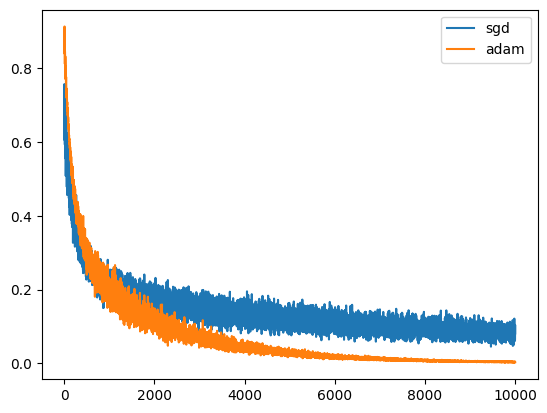

In [30]:
plt.plot(sgd_sol, label="sgd")
plt.plot(adam_sol, label="adam")
# plt.plot(adagrad_sol, label="adagrad")
plt.legend()
plt.show()

In [22]:
_, adam_sol_successive = solve_problem(LogisticModel, 
              logit_criterion,
              SuccessiveSampler,
              optimizer_class=torch.optim.Adam,
              dataset=clustered_data,
              batch_size=64,
              verbose=True)

Building models...


100%|██████████| 10000/10000 [00:09<00:00, 1085.69it/s]


In [29]:
_, adam_sol_cluster = solve_problem(LogisticModel, 
              logit_criterion,
              ClusterSampler,
              optimizer_class=torch.optim.Adam,
              dataset=clustered_data,
              batch_size=64,
              verbose=True)

Building models...


100%|██████████| 10000/10000 [00:13<00:00, 767.21it/s]


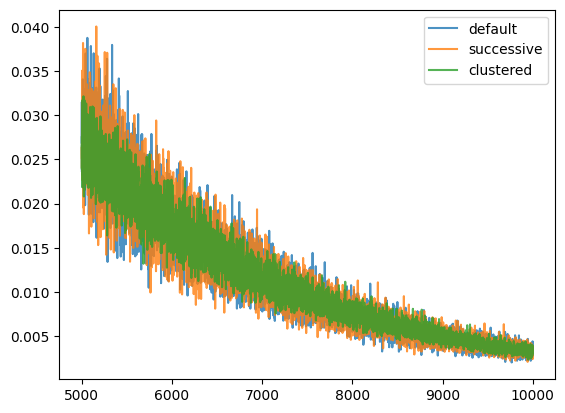

In [ ]:
plt.plot(range(5000, 10000), adam_sol[5000:], label="default", alpha=0.8)
plt.plot(range(5000, 10000), adam_sol_successive[5000:], label="successive", alpha=0.8)
plt.plot(range(5000, 10000), adam_sol_cluster[5000:], label="clustered", alpha=0.8)
plt.legend()
# plt.loglog()
plt.title("using Adam with different sampling techniques")
plt.show()

In [37]:
_, sgd_sol_successive = solve_problem(LogisticModel, 
              logit_criterion,
              SuccessiveSampler,
              optimizer_class=torch.optim.SGD,
              dataset=clustered_data,
              batch_size=64,
              verbose=True)

_, sgd_sol_cluster = solve_problem(LogisticModel, 
              logit_criterion,
              ClusterSampler,
              optimizer_class=torch.optim.SGD,
              dataset=clustered_data,
              batch_size=64,
              verbose=True)

Building models...


100%|██████████| 10000/10000 [00:07<00:00, 1333.30it/s]


Building models...


100%|██████████| 10000/10000 [00:08<00:00, 1165.13it/s]


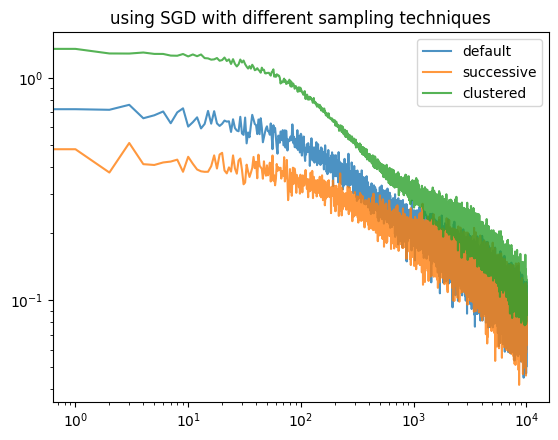

In [38]:
plt.plot(sgd_sol, label="default", alpha=0.8)
plt.plot(sgd_sol_successive, label="successive", alpha=0.8)
plt.plot(sgd_sol_cluster, label="clustered", alpha=0.8)
plt.legend()
plt.loglog()
plt.title("using SGD with different sampling techniques")
plt.show()